# Consolidated Classification Analysis for Commercial Models


This notebook merges multiple classification result files produced for commercial models and performs an in-depth analysis with visualizations. The goal is to understand how each model behaves (Plano vs. Técnico) and how consistent the models are with one another.

In [51]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from itertools import combinations

sns.set_theme(style="whitegrid", palette="husl")
plt.rcParams.update({
    "figure.figsize": (12, 6),
    "axes.titlesize": 14,
    "axes.labelsize": 12
})

## 1. Load classification outputs

We begin by loading the two CSV files produced from the commercial models classification step. Each file contains predictions (`Plano` or `Técnico`) and the generated text for each model.

In [52]:
# Define file paths
base_path = Path(".")
file_a = base_path / "commercial_models_results_test_200examples_classification.csv"
file_b = base_path / "commercial_models_results_test_200examples_2_classification.csv"

if not file_a.exists() or not file_b.exists():
    missing = [str(p) for p in [file_a, file_b] if not p.exists()]
    raise FileNotFoundError(f"Missing required file(s): {missing}")

raw_a = pd.read_csv(file_a)
raw_b = pd.read_csv(file_b)

print("File A:", file_a.name, raw_a.shape)
print("File B:", file_b.name, raw_b.shape)
raw_a.head(1)

File A: commercial_models_results_test_200examples_classification.csv (200, 9)
File B: commercial_models_results_test_200examples_2_classification.csv (200, 9)


,row_index,source_text,target_text,generated_claude-sonnet-4-5_prediction_int,generated_claude-sonnet-4-5_prediction_label,generated_claude-sonnet-4-5_text,generated_chatgpt-5_prediction_int,generated_chatgpt-5_prediction_label,generated_chatgpt-5_text
0,0,Background\nThis review is an update of a prev...,Local anaesthetic sympathetic blockade for com...,0,Plano,# Plain Language Summary: Local Anesthetic Ner...,0,Plano,Plain-language summary\n\nPurpose\n- To see if...


## 2. Transform files into a unified long-format table

Each CSV stores predictions in wide format (one column per model). To facilitate analysis we reshape them into a long table where each row corresponds to `(document, model)` with its label, numeric value, and auxiliary metadata.

In [53]:
MODEL_ALIASES = {
    "generated_claude-sonnet-4-5": "Claude 4.5 Sonnet",
    "generated_chatgpt-5": "GPT-5",  # keep naming consistent with source file
    "claude-haiku-4-5": "Claude 4.5 Haiku",
    "gpt-4o": "GPT-4o",
}

SUFFIXES = {
    "prediction_label": "_prediction_label",
    "prediction_int": "_prediction_int",
    "generated_text": "_text",
}


def _strip_suffix(column_name: str) -> str:
    for suffix in SUFFIXES.values():
        if column_name.endswith(suffix):
            return column_name[: -len(suffix)]
    return column_name


def reshape_classification(df: pd.DataFrame, file_origin: str) -> pd.DataFrame:
    """Convert a wide-format classification DataFrame into long format."""
    prediction_cols = [c for c in df.columns if c.endswith(SUFFIXES["prediction_label"])]
    if not prediction_cols:
        raise ValueError("No prediction columns found in the provided DataFrame.")

    records = []

    for _, row in df.iterrows():
        row_index = row.get("row_index")
        source_text = row.get("source_text")
        target_text = row.get("target_text")

        for pred_col in prediction_cols:
            base = _strip_suffix(pred_col)
            int_col = base + SUFFIXES["prediction_int"]
            text_col = base + SUFFIXES["generated_text"]

            model_key = base
            model_name = MODEL_ALIASES.get(model_key, model_key.replace("generated_", "").replace("_", " ").title())

            label = row.get(pred_col)
            pred_int = row.get(int_col)
            generated_text = row.get(text_col)
            text_len = len(str(generated_text)) if pd.notna(generated_text) else 0

            records.append(
                {
                    "row_index": row_index,
                    "model_key": model_key,
                    "model": model_name,
                    "prediction_label": label,
                    "prediction_int": pred_int,
                    "generated_text": generated_text,
                    "text_length": text_len,
                    "source_text": source_text,
                    "target_text": target_text,
                    "file_origin": file_origin,
                }
            )

    return pd.DataFrame(records)

In [54]:
long_a = reshape_classification(raw_a, file_a.name)
long_b = reshape_classification(raw_b, file_b.name)

merged_long = pd.concat([long_a, long_b], ignore_index=True)
merged_long["prediction_label"] = merged_long["prediction_label"].fillna("Desconocido")

print("Long format shape:", merged_long.shape)
merged_long.head()

Long format shape: (800, 10)


,row_index,model_key,model,prediction_label,prediction_int,generated_text,text_length,source_text,target_text,file_origin
0,0,generated_claude-sonnet-4-5,Claude 4.5 Sonnet,Plano,0,# Plain Language Summary: Local Anesthetic Ner...,1706,Background\nThis review is an update of a prev...,Local anaesthetic sympathetic blockade for com...,commercial_models_results_test_200examples_cla...
1,0,generated_chatgpt-5,GPT-5,Plano,0,Plain-language summary\n\nPurpose\n- To see if...,1849,Background\nThis review is an update of a prev...,Local anaesthetic sympathetic blockade for com...,commercial_models_results_test_200examples_cla...
2,1,generated_claude-sonnet-4-5,Claude 4.5 Sonnet,Plano,0,# Plain Language Summary: Anti-Angiogenic Drug...,2028,Background\nThis is an updated version of the ...,Drugs that target blood vessels in malignant b...,commercial_models_results_test_200examples_cla...
3,1,generated_chatgpt-5,GPT-5,Plano,0,Plain-Language Summary: Anti-angiogenic therap...,2097,Background\nThis is an updated version of the ...,Drugs that target blood vessels in malignant b...,commercial_models_results_test_200examples_cla...
4,2,generated_claude-sonnet-4-5,Claude 4.5 Sonnet,Plano,0,# Plain Language Summary: Comparing Different ...,2284,Background\nImplant overdentures are one of th...,Attachments for implant dentures\nReview quest...,commercial_models_results_test_200examples_cla...


## 3. Persist the merged dataset

We save the unified long-format table so it can be reused elsewhere without regenerating predictions.

In [55]:
output_long = file_a.with_name("commercial_models_results_test_200examples_classification_merged_long.csv")
merged_long.to_csv(output_long, index=False)
print(f"Merged file written to: {output_long}")

Merged file written to: commercial_models_results_test_200examples_classification_merged_long.csv


## 4. Descriptive statistics

We compute per-model distributions, technical rates, and other aggregated insights to understand how each commercial model behaves.

In [56]:
merged_long["prediction_int_numeric"] = pd.to_numeric(merged_long["prediction_int"], errors="coerce")

label_distribution = (
    merged_long.groupby(["model", "prediction_label"])
    .size()
    .unstack(fill_value=0)
    .sort_index()
)

model_summary = (
    merged_long.groupby("model").agg(
        total_predictions=("prediction_label", "count"),
        technical_rate=("prediction_int_numeric", "mean"),
        avg_text_length=("text_length", "mean"),
    )
    .sort_values("total_predictions", ascending=False)
)
model_summary["technical_rate"] = model_summary["technical_rate"].fillna(0)
model_summary

,total_predictions,technical_rate,avg_text_length
model,,,
Claude 4.5 Haiku,200,0.00,1685.600
Claude 4.5 Sonnet,200,0.23,1410.465
GPT-4o,200,0.00,1610.950
GPT-5,200,0.24,1640.550


In [57]:
label_distribution

prediction_label,Plano,Técnico
model,,
Claude 4.5 Haiku,200,0
Claude 4.5 Sonnet,154,46
GPT-4o,200,0
GPT-5,152,48


### Pairwise agreement between models

We compare models on overlapping documents to see how often they assign the same label.

In [58]:
wide_labels = merged_long.pivot_table(
    index="row_index",
    columns="model",
    values="prediction_label",
    aggfunc="first"
)

models = sorted(merged_long["model"].unique())
agreement_matrix = pd.DataFrame(index=models, columns=models, dtype=float)

for m1, m2 in combinations(models, 2):
    overlap = wide_labels[[m1, m2]].dropna()
    if not overlap.empty:
        agreement = (overlap[m1] == overlap[m2]).mean()
        agreement_matrix.loc[m1, m2] = agreement
        agreement_matrix.loc[m2, m1] = agreement

np.fill_diagonal(agreement_matrix.values, 1.0)
agreement_matrix

,Claude 4.5 Haiku,Claude 4.5 Sonnet,GPT-4o,GPT-5
Claude 4.5 Haiku,1.00,0.77,1.00,0.76
Claude 4.5 Sonnet,0.77,1.00,0.77,0.99
GPT-4o,1.00,0.77,1.00,0.76
GPT-5,0.76,0.99,0.76,1.00


## 5. Visualizations

We generate a series of charts to highlight distribution differences, technical rates, text-length characteristics, and agreement patterns across models.

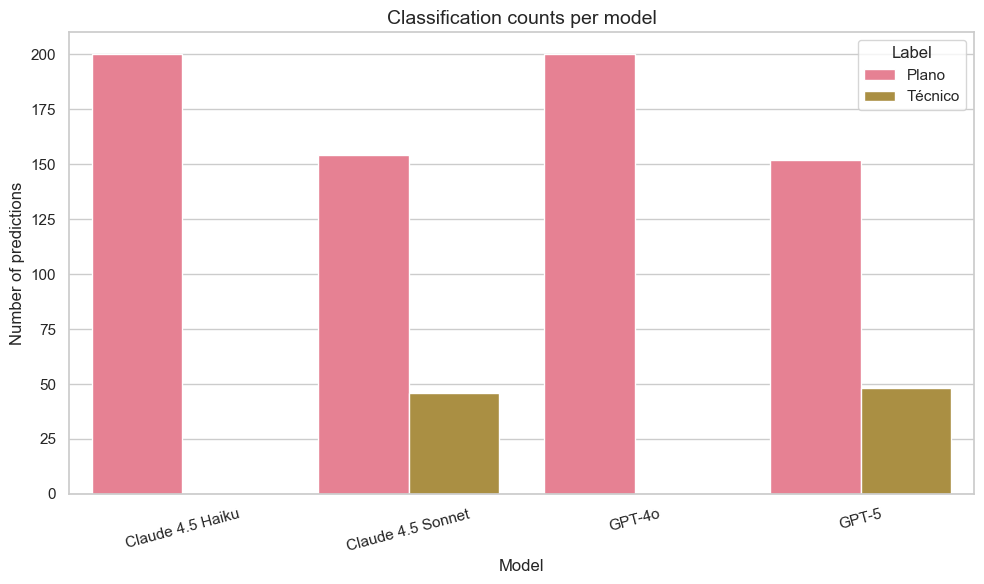

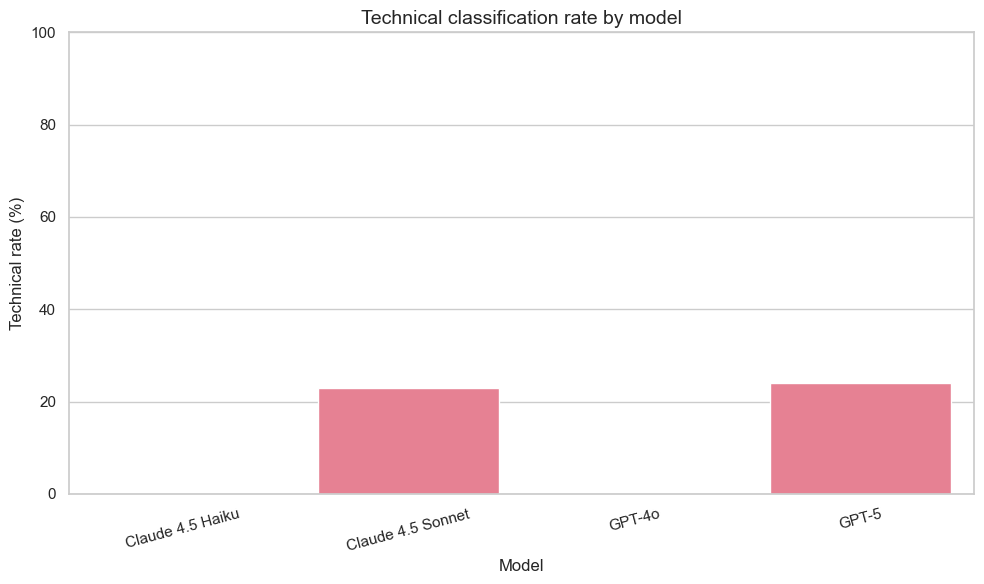

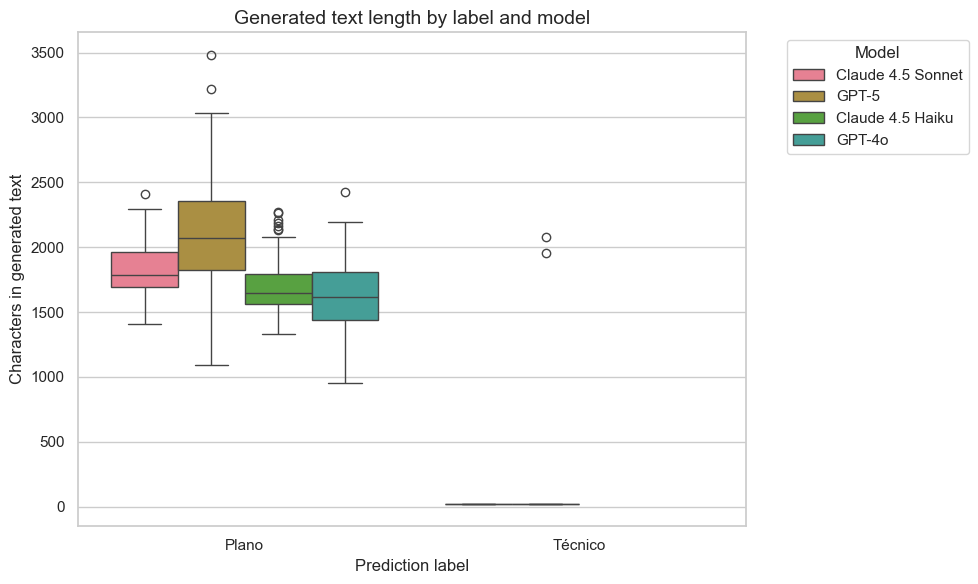

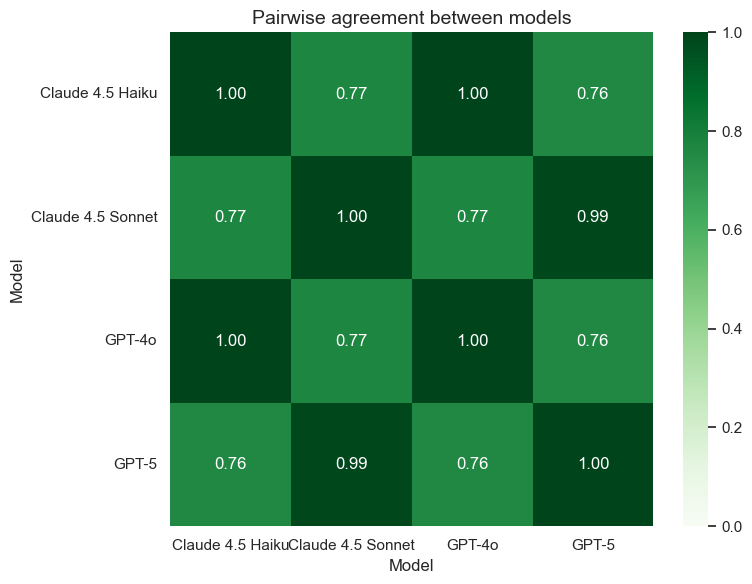

In [59]:
# Plot 1: Label distribution by model
plt.figure(figsize=(10, 6))
sns.countplot(data=merged_long, x="model", hue="prediction_label", order=model_summary.index)
plt.xticks(rotation=15)
plt.title("Classification counts per model")
plt.xlabel("Model")
plt.ylabel("Number of predictions")
plt.legend(title="Label")
plt.tight_layout()
plt.show()

# Plot 2: Technical rate (percentage of 'Técnico')
plt.figure(figsize=(10, 6))
rate_data = model_summary.reset_index()
rate_data["technical_rate_pct"] = rate_data["technical_rate"] * 100
sns.barplot(data=rate_data, x="model", y="technical_rate_pct", order=model_summary.index)
plt.xticks(rotation=15)
plt.title("Technical classification rate by model")
plt.ylabel("Technical rate (%)")
plt.xlabel("Model")
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

# Plot 3: Text length distribution by prediction label
plt.figure(figsize=(10, 6))
sns.boxplot(data=merged_long, x="prediction_label", y="text_length", hue="model")
plt.title("Generated text length by label and model")
plt.xlabel("Prediction label")
plt.ylabel("Characters in generated text")
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# Plot 4: Agreement heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(agreement_matrix.astype(float), annot=True, fmt=".2f", cmap="Greens", vmin=0, vmax=1)
plt.title("Pairwise agreement between models")
plt.xlabel("Model")
plt.ylabel("Model")
plt.tight_layout()
plt.show()

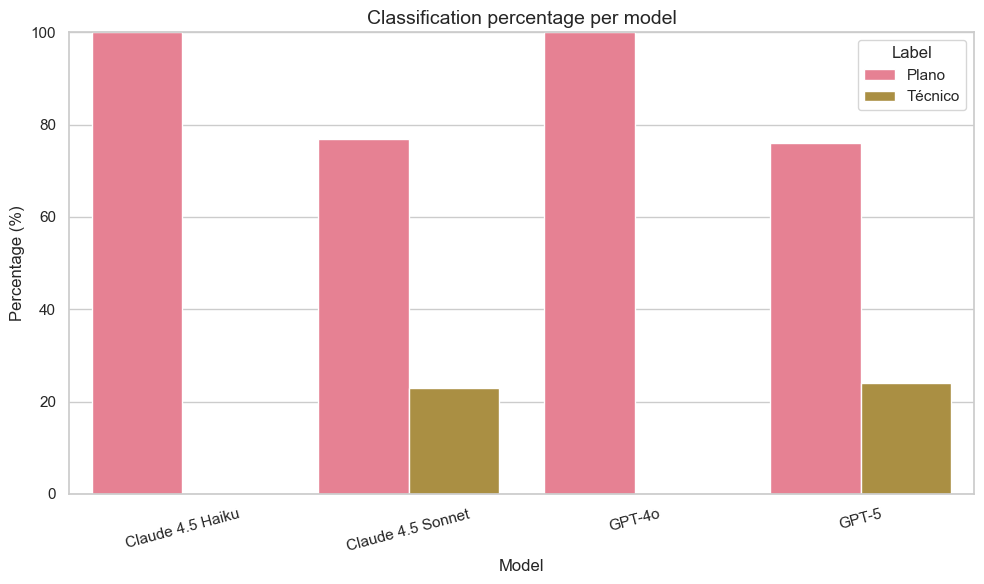

In [60]:
# Plot 5: Percentage distribution of labels by model
percentage_df = (
    merged_long.groupby(["model", "prediction_label"]).size()
    .groupby(level=0)
    .transform(lambda counts: counts / counts.sum() * 100)
    .reset_index(name="percentage")
)

order_models = (
    list(model_summary.index)
    if "model_summary" in locals() and model_summary is not None
    else list(percentage_df["model"].unique())
)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=percentage_df,
    x="model",
    y="percentage",
    hue="prediction_label",
    order=order_models,
)
plt.xticks(rotation=15)
plt.title("Classification percentage per model")
plt.xlabel("Model")
plt.ylabel("Percentage (%)")
plt.ylim(0, 100)
plt.legend(title="Label")
plt.tight_layout()
plt.show()

## 6. Key takeaways

- The merged dataset contains all four commercial models, enabling side-by-side comparisons.
- `model_summary` highlights overall technical rates and average generation length to spot stylistic differences.
- Agreement analysis flags where models diverge, which can guide ensemble or human review strategies.

You can now rerun specific cells to refresh the analysis if new classification CSVs become available.